In [1]:
%load_ext autoreload

%autoreload 2

In [181]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
import torch
import torch as tc
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from  torch.utils.data import DataLoader
import torch.optim.lr_scheduler as lr_scheduler
import matplotlib.pyplot as plt
%matplotlib inline
import torchvision.datasets as dset
import numpy as np
import cv2

from center_loss import CenterLoss
from frw import L2_penalty_with_constant
from reid_model import ReID_Net
from datasets import CUHK03, Market1501
from custom_transforms import RandomTranslation
from evaluation import pairwise_squared_euclidian_distance, generate_split_cuhk03, get_topk_results, apk, mapk, generate_query, calculate_mAP
import time
import shutil

## Avaliação do modelo treinado

In [9]:
!ls trained_models

cuhk01_finetuned.pth  market1501_trained.pth	   viper_finetuned.pth
cuhk03_trained.pth    transfer_learning_model.pth


In [5]:
model = ReID_Net.from_checkpoint('trained_models/cuhk03_trained.pth')
model = model.cuda()
model = model.eval()

In [8]:
data_transforms = transforms.Compose([
    transforms.ToTensor(),                    # = transpose(0,3,1,2), range [0, 1]
    transforms.Lambda(lambda t: t/0.5 - 1)    # = range [-1, 1]
])

dataset = CUHK03('../reid/datasets/cuhk03_test_correct.npz', train=False, test=True,
                 transform=data_transforms)

dloader = DataLoader(dataset, batch_size=100, shuffle=False)

In [144]:
X_querygal = dataset.X
y_querygal = dataset.y
cam_ids = dataset.cam_ids

print('Número de identidades para teste: ', len(np.unique(y_querygal)))
print('Número de câmeras distintas: ', len(np.unique(cam_ids)))

Número de identidades para teste:  100
Número de câmeras distintas:  2


## Conceito de split:
É usado  o método de 'cross-camera search': uma câmera é usada pra Query (consulta) e a(s) outra(s) para Gallery.
Para cada identidade no conjunto de Query (consulta), é escolhida aleatoriamente uma imagem de cada pessoa no conjunto Query e 1 imagem da mesma identidade das câmeras da Galeria.

Exemplo de split:

In [171]:
querygal_split = generate_split_cuhk03(y_querygal, cam_ids)
print(querygal_split)

{'query': array([  7,  13,  24,  35,  46,  54,  66,  74,  85,  95, 101, 114, 124,
       135, 143, 154, 165, 174, 181, 192, 204, 213, 220, 233, 239, 252,
       263, 270, 278, 287, 296, 308, 317, 325, 333, 344, 353, 365, 371,
       384, 391, 402, 410, 420, 432, 444, 452, 461, 469, 481, 489, 499,
       511, 522, 532, 538, 550, 560, 569, 577, 586, 598, 606, 616, 629,
       633, 645, 655, 664, 675, 685, 694, 706, 713, 722, 734, 745, 752,
       766, 772, 782, 794, 803, 813, 822, 834, 843, 854, 861, 872, 881,
       893, 904, 915, 921, 926, 935, 944, 954, 963]), 'gallery': array([  1,   9,  21,  29,  40,  48,  58,  69,  76,  90,  98, 107, 120,
       129, 136, 149, 158, 170, 180, 187, 196, 208, 215, 225, 237, 248,
       255, 266, 277, 285, 292, 302, 310, 319, 328, 340, 350, 359, 368,
       379, 386, 398, 406, 416, 427, 437, 447, 453, 466, 473, 487, 495,
       503, 517, 526, 535, 546, 552, 563, 574, 582, 592, 602, 613, 624,
       630, 640, 651, 660, 671, 681, 690, 698, 711, 719, 730,

# Extraindo as features do conjunto de Query

In [172]:
querygal_features = []

model = model.cuda()
model.eval()

for X, y in dloader:
    X = Variable(X.cuda(), volatile=True)
    
    batch_features = model.get_embeddings(X)
    querygal_features.append(batch_features.data.cpu())
    
querygal_features = torch.cat(querygal_features, dim=0)

In [173]:
print(querygal_features.size())

torch.Size([965, 512])


In [174]:
distances = pairwise_squared_euclidian_distance(querygal_features, querygal_features)
print(distances.size())

torch.Size([965, 965])


In [175]:
# Ids de do conjunto Query+Gallery em ordem crescente de distância
# O split possui 100 índices para Query e 100 para Gallery: 1 imagem de cada pessoa em cada conjunto, sendo de
# de câmeras distintas

rankings = querygal_split['gallery'][get_topk_results(distances, 10, querygal_split).numpy()]
print(rankings[:10])
print('...')
print(rankings.shape)

[[  1 248  76 107 427 158  69 941 379 180]
 [  9 187 107  58 129 917  21 158  76 319]
 [ 21 319 602  98 487 386 215 917 740 406]
 [ 29 285 630 535 526 406 503  40 248 487]
 [ 40 406 503 170 359 602 350 535 466 398]
 [416  48  90 526 447 208 310 255 466 180]
 [ 58 187   9 158 129 107 563 917 386  21]
 [ 69 196 368 237 277 292 447 453 136  90]
 [ 76 107 563 158   1 248 187 129 917   9]
 [ 90 292 437 208 158 129 248  69 359 386]]
...
(100, 10)


### Visualizando um rank-5

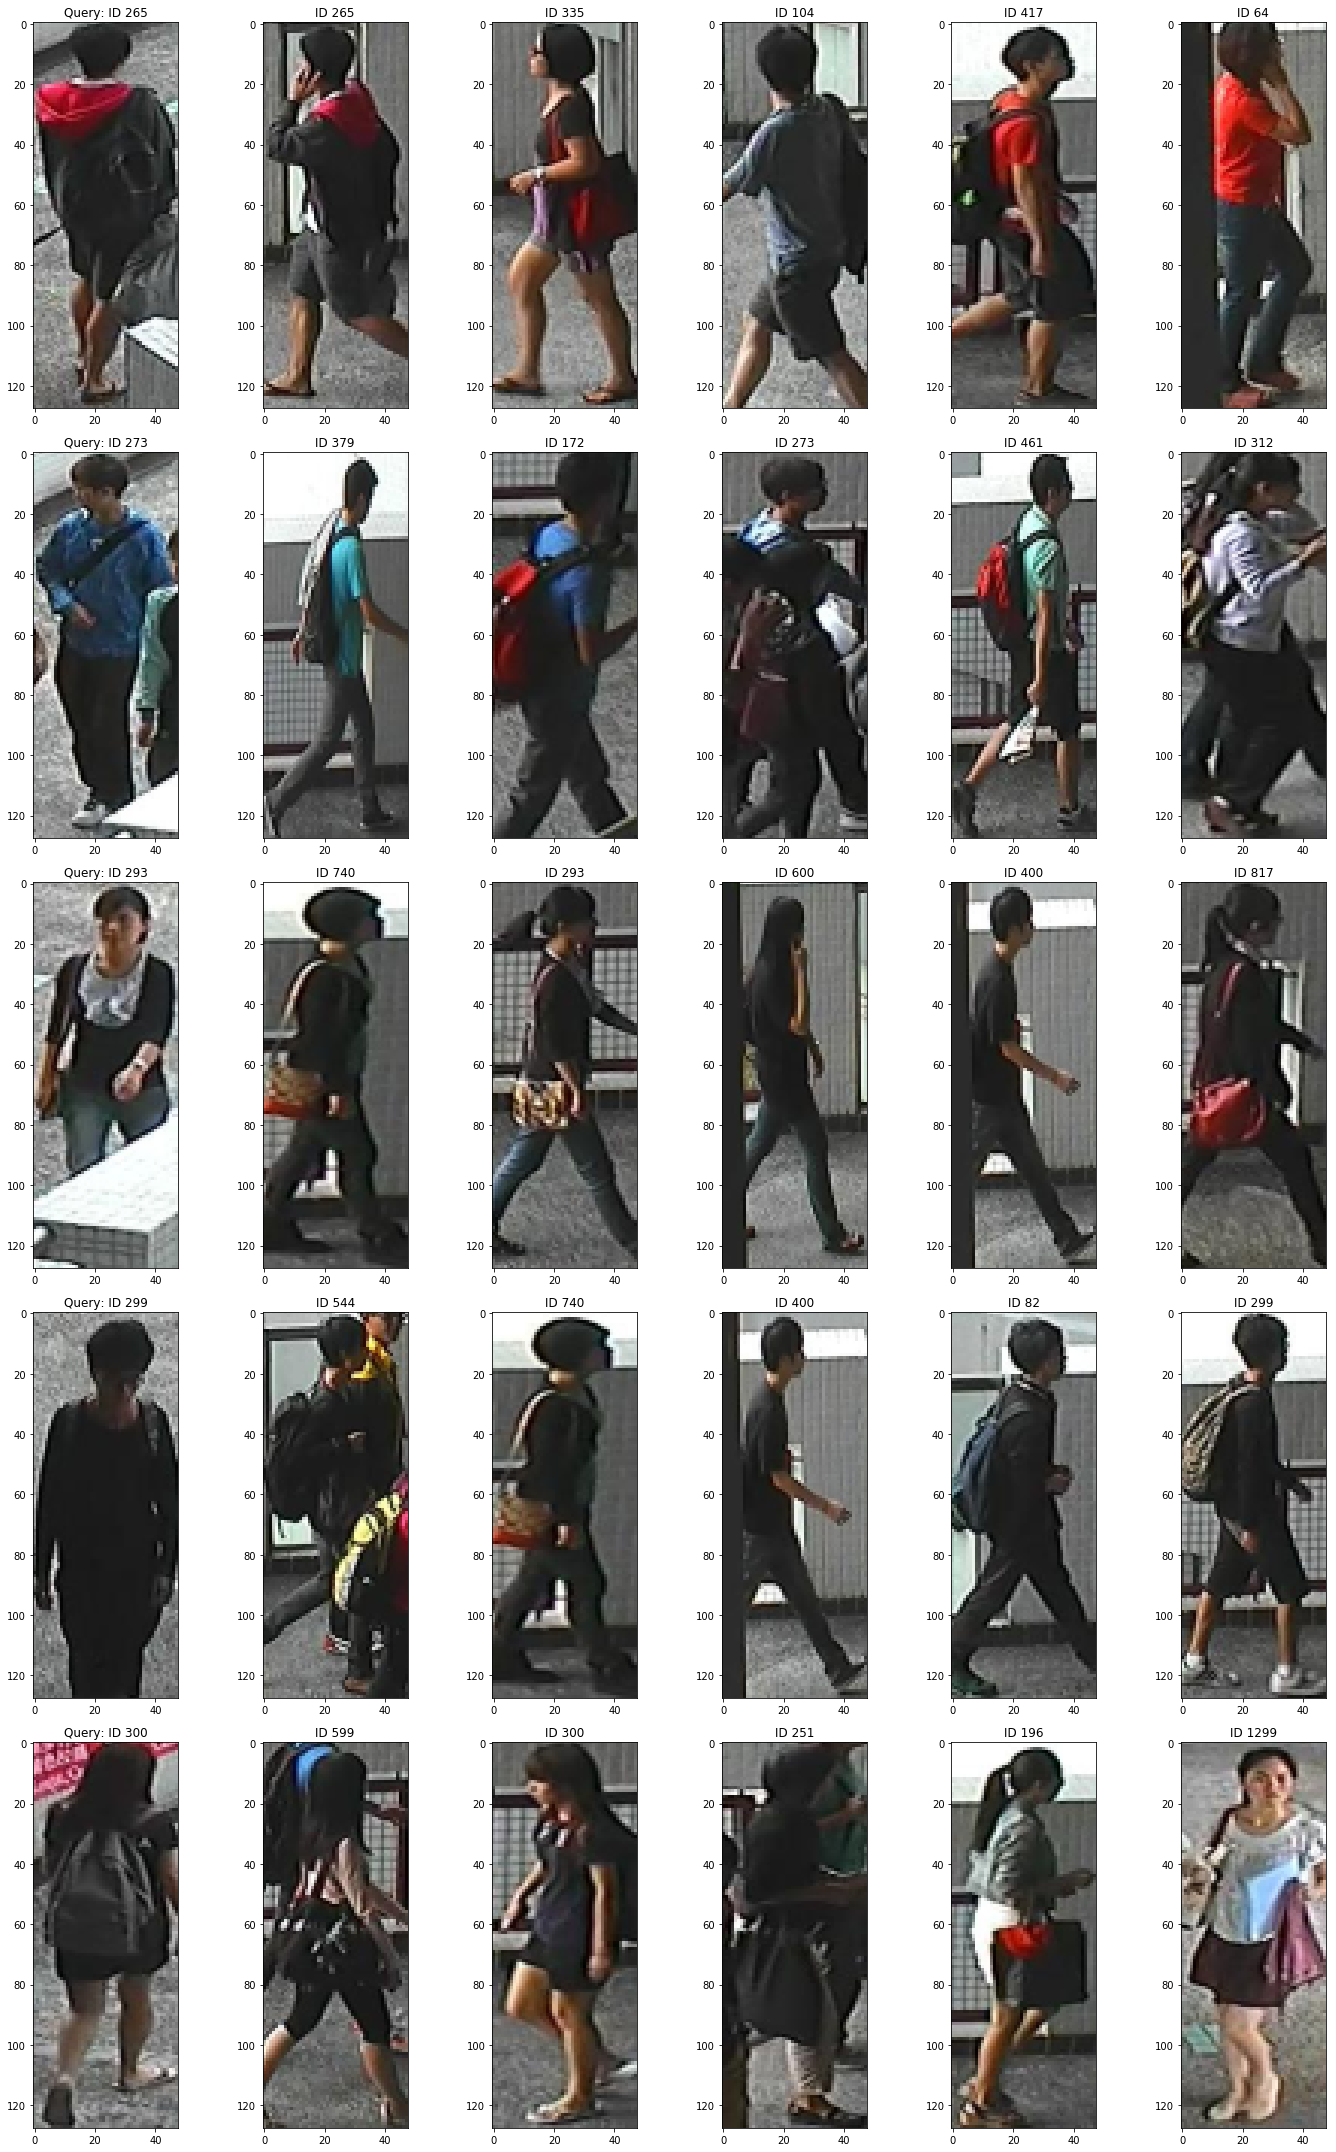

In [176]:
# Visualizando alguns rankings:
K = 5
N_cols = K+1

offset = 20

plt.figure(figsize=(20, 30))
for j in range(5):
    q_indice = querygal_split['query'][offset+j]
    #print(q_indice)
    ranking = rankings[offset+j, :K]
    #print(ranking)
    
    plt.subplot(5, K+1, (j*N_cols)+1)
    plt.imshow(X_querygal[q_indice])
    plt.title('Query: ID {}'.format(y_querygal[q_indice]))
    
    for i in range(K):
        plt.subplot(5, N_cols, (j*N_cols)+i+2)
        plt.imshow(X_querygal[ranking[i]])
        plt.title('ID {}'.format(y_querygal[ranking[i]]))
        
    plt.tight_layout()

### Visualizando um rank-10

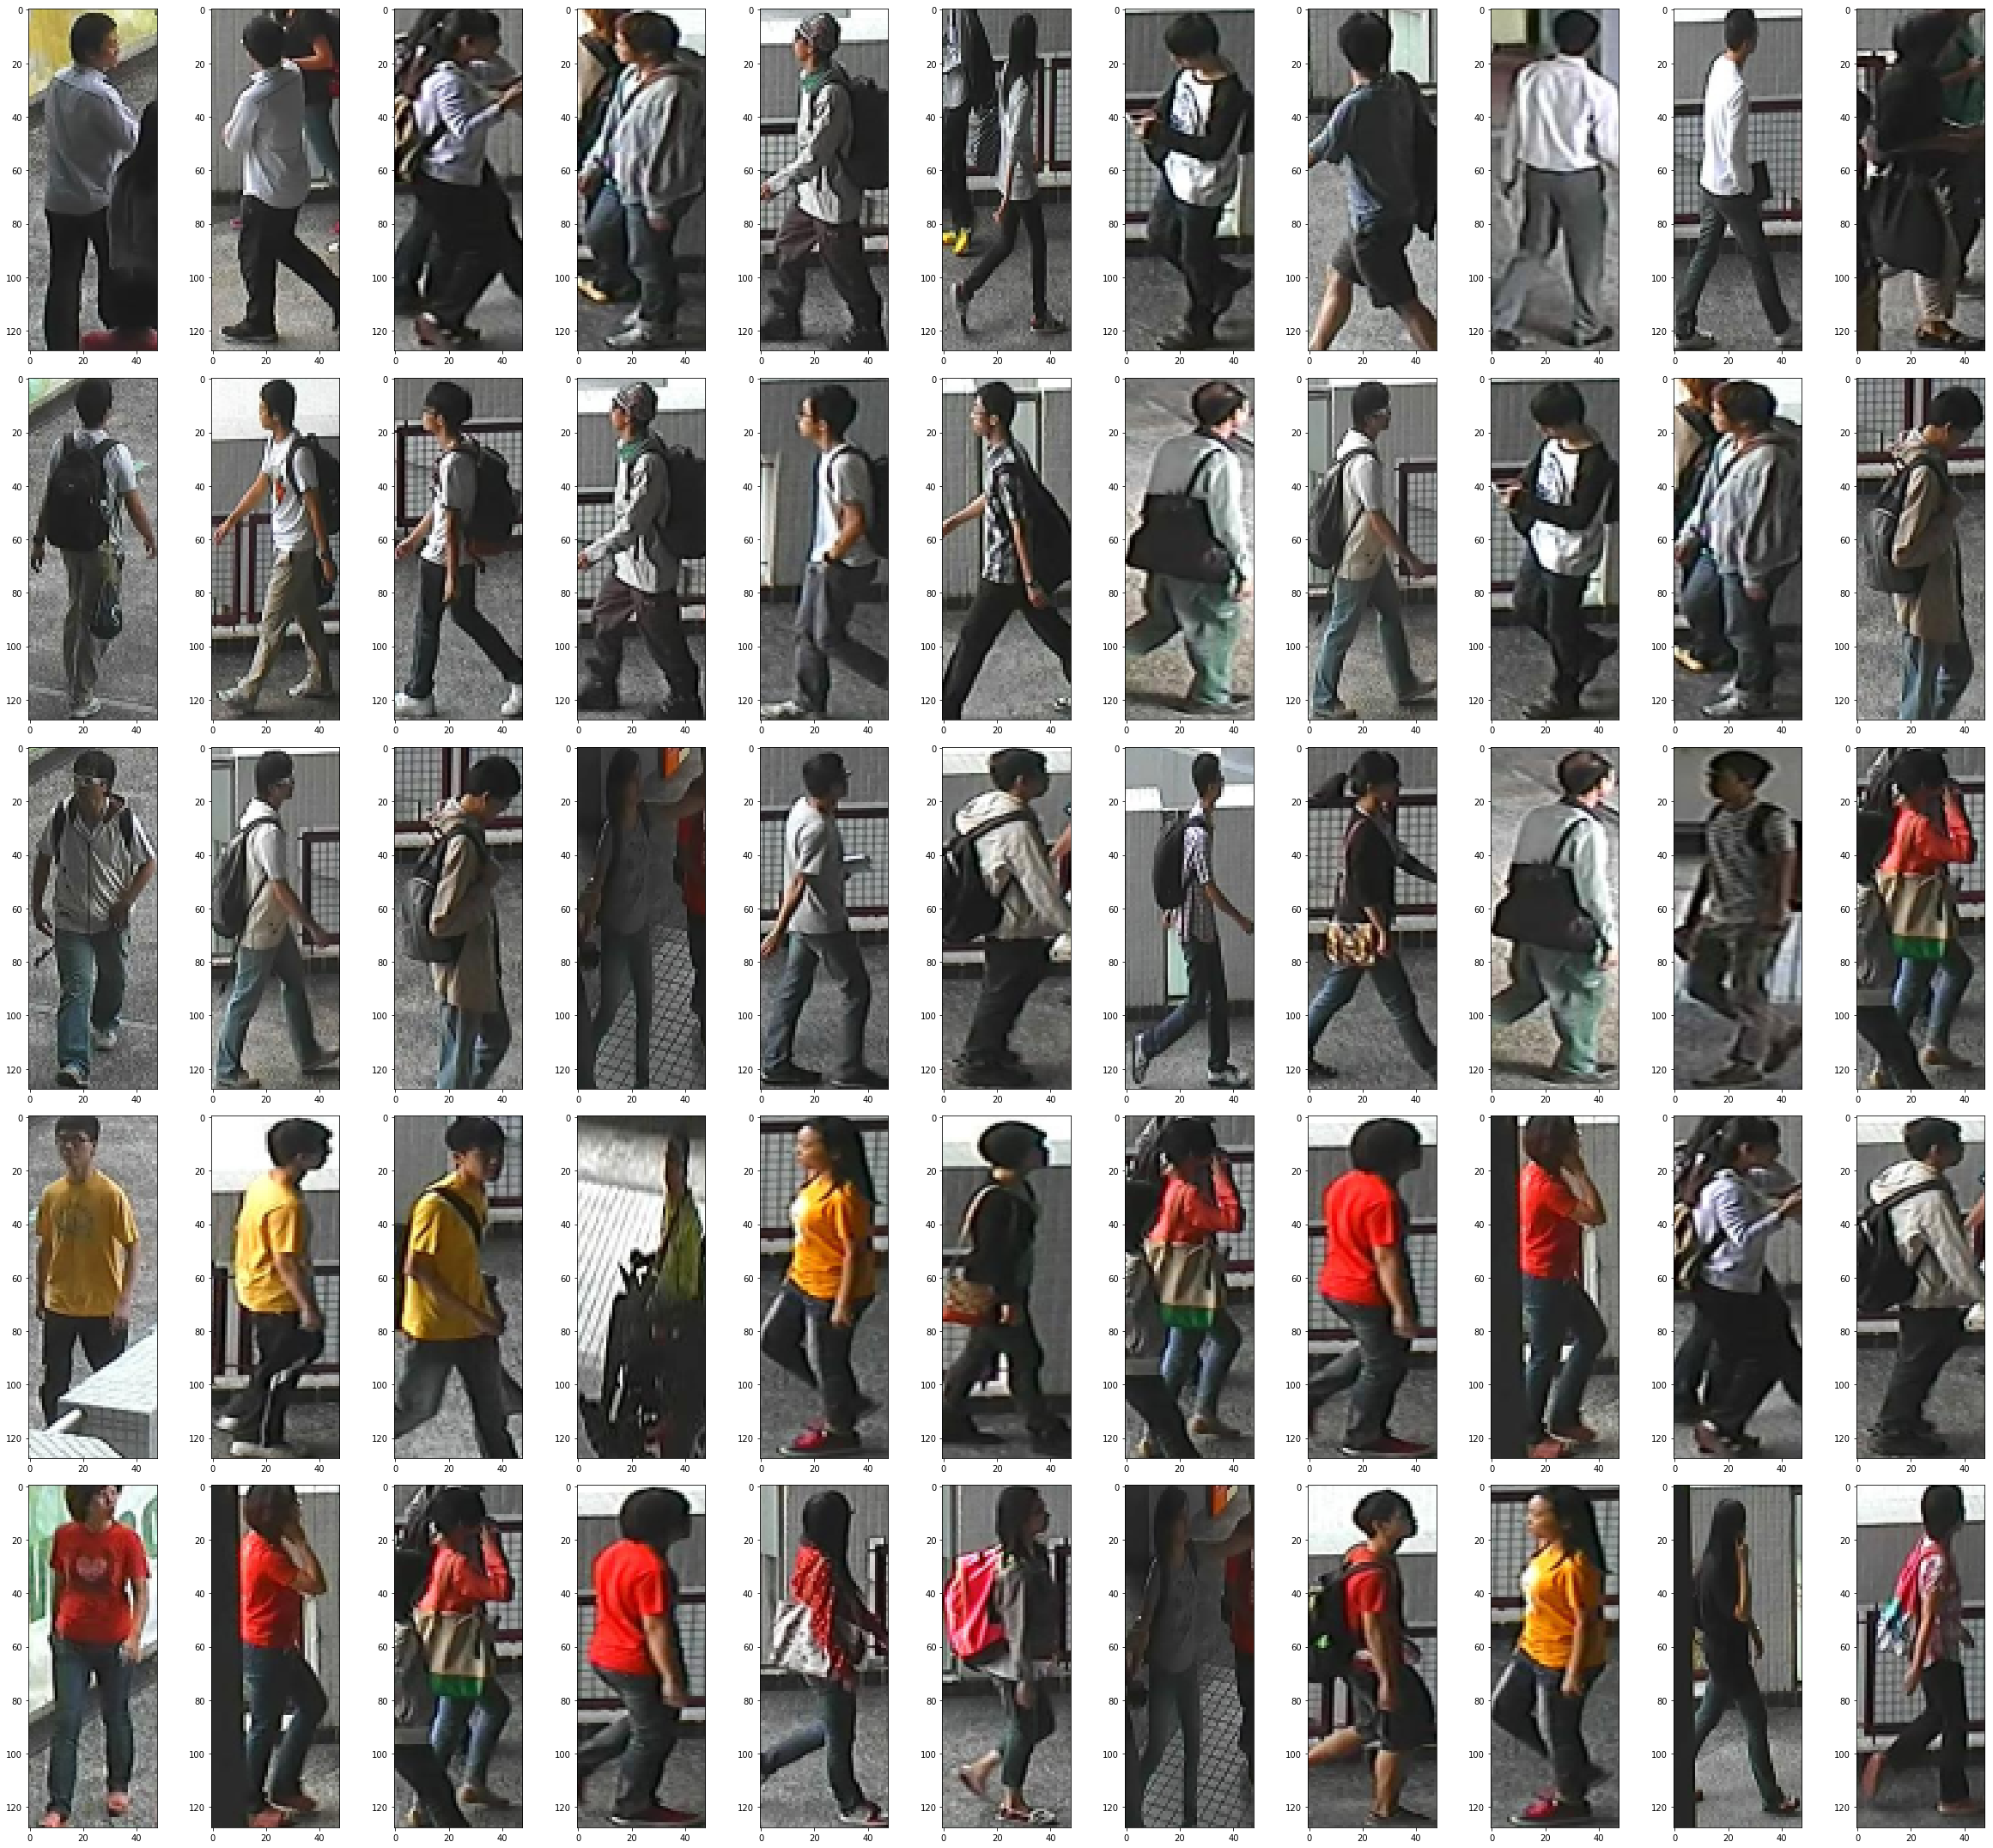

In [178]:
# Visualizando alguns rankings:
plt.figure(figsize=(33, 30))
for j in range(5):
    q_indice = querygal_split['query'][j]
    ranking = rankings[j, :]
    
    plt.subplot(5, 11, (j*11)+1)
    plt.imshow(X_querygal[q_indice])
    
    for i in range(10):
        plt.subplot(5, 11, (j*11)+i+2)
        plt.imshow(X_querygal[ranking[i]])
        
    plt.tight_layout()

In [149]:
query_pids = y_querygal[querygal_split['query']]
matched_pids = y_querygal[rankings]
print('Identidades de Query:')
print(query_pids[:20, np.newaxis])
print()
print('Identidades dos matches para cada Query (linha):')
print(matched_pids[:20])

Identidades de Query:
[[  3]
 [ 17]
 [ 29]
 [ 60]
 [ 64]
 [ 82]
 [ 97]
 [104]
 [119]
 [127]
 [141]
 [143]
 [172]
 [191]
 [196]
 [219]
 [230]
 [235]
 [251]
 [253]]

Identidades dos matches para cada Query (linha):
[[   3  312  143  838  472  565 1325  542  415  119]
 [  17  253  143   97  499  300  838 1284  415  786]
 [  29  861  403  141  499  400  629  293  542  143]
 [  60  345  887  542  534  629  740  748  312  684]
 [  64  684  542  235  417  534  422  748  141  293]
 [  82  544  740  587  273  127  219  293  600  400]
 [  97  499  253   17  230  786   29  143  861  330]
 [ 104  461  265  251  335  359  587  300  196  599]
 [ 119  143  786    3  312   17  253 1229   97  230]
 [ 127  273  359  499  403  832  312  172  565  542]
 [ 141  499   29  403  472  312  400  861  629  415]
 [ 143  119  253  330  786  499  629  191  832  312]
 [ 172  273 1252  127  379  623  499  542  587  403]
 [ 253  191  330  273  230  499  786  127  941  104]
 [ 196  832  587  143  565  127  312  422  40

In [99]:
# rank-10 para esse split:
np.mean(np.sum(matched_pids[:, :10] == query_pids[:, np.newaxis], axis=1))

1.0

In [167]:
def calculate_rank_k(k, query_pids, matched_pids):
    correct = 0
    # Para cada identidade (pid), verifica se ela está presente nas identidades retornadas pelo rank
    # até a k-ésima posição
    for i, pid in enumerate(query_pids):
        if pid in matched_pids[i, :k]:
            correct += 1
            
    return correct / len(query_pids)


In [168]:
print('Rank-1: ', calculate_rank_k(1, query_pids, matched_pids))
print('Rank-5: ', calculate_rank_k(5, query_pids, matched_pids))
print('Rank-10: ', calculate_rank_k(10, query_pids, matched_pids))

Rank-1:  0.78
Rank-5:  0.99
Rank-10:  1.0


# Cálculo do CMC

In [179]:
def calculate_cmc(y_querygal, cam_ids, features, N_splits=20, ranks=[1, 5, 10]):
    # Calcula as distâncias entre cada par de features
    distances = pairwise_squared_euclidian_distance(features, features)
    
    cmcs = {k: [] for k in ranks}

    
    # Para cada execução
    for n in range(N_splits):
        # Gera um split de Query e Galeria
        querygal_split = generate_split_cuhk03(y_querygal, cam_ids)
        rankings = querygal_split['gallery'][get_topk_results(distances, int(max(ranks)),
                                                              querygal_split).numpy()]
        
        query_pids = y_querygal[querygal_split['query']]
        matched_pids = y_querygal[rankings]
        
        for k in ranks:
            correct = 0
            # Para cada identidade (pid), verifica se ela está presente nas identidades retornadas pelo rank
            # até a k-ésima posição
            for i, pid in enumerate(query_pids):
                if pid in matched_pids[i, :k]:
                    correct += 1
            
            # média de acertos
            cmcs[k].append(correct / len(query_pids))
        
    for k, rank in cmcs.items():
        cmcs[k] = np.mean(rank)
    
    return cmcs

In [180]:
calculate_cmc(y_querygal, cam_ids, querygal_features, N_splits=100)

{1: 0.76860000000000017, 5: 0.96349999999999991, 10: 0.98499999999999999}

# Cálculo mAP

In [200]:
# Para cada execução
N_executions = 50

mAPs = []

for n in range(N_executions):
    # Gera um split de Query e Galeria
    query_indices_by_cam = generate_query(y_querygal, cam_ids)
    
    mAPs.append(calculate_mAP(query_indices_by_cam, querygal_features, y_querygal, cam_ids))
    
print('mAP final: ', np.mean(mAPs))
#     rankings = querygal_split['gallery'][get_topk_results(distances, int(max(ranks)),
#                                                           querygal_split).numpy()]

#     query_pids = y_querygal[querygal_split['query']]
#     matched_pids = y_querygal[rankings]

#     for k in ranks:
#         correct = 0
#         # Para cada identidade (pid), verifica se ela está presente nas identidades retornadas pelo rank
#         # até a k-ésima posição
#         for i, pid in enumerate(query_pids):
#             if pid in matched_pids[i, :k]:
#                 correct += 1

#         # média de acertos
#         cmcs[k].append(correct / len(query_pids))

# for k, rank in cmcs.items():
#     cmcs[k] = np.mean(rank)

mAP final:  0.798160083708
